# Practical 3: Transfer Learning

This is the second task of Practical 3. You will use transfer learning to build a convolutional neural network to tackle the CIFAR-10 dataset (https://www.cs.toronto.edu/~kriz/cifar.html). 
You could select an existing trained model (VGG16 excluded) from Keras (https://keras.io/api/applications/) and fine-tune it to solve the classification problem of CIFAR-10. 

We will mark your code based on the accuracy of your model. You should try to get **at least 80%** accuracy on this dataset. Don't forget to save and check in your model. 

## Import the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.layers import GlobalAveragePooling2D
from keras.applications.resnet50 import ResNet50, preprocess_input

## Prepare the dataset

In this block, you will prepare the data for the training, such as apply the preprocess function of your selected model and perform data augmentation. 

In [2]:
from keras.datasets import cifar10
(X_train_full, y_train_full), (X_test, y_test) = cifar10.load_data()
X_train_full.shape

(50000, 32, 32, 3)

In [3]:
# ResNet50 preprocess
X_train_full = preprocess_input(X_train_full)
X_test = preprocess_input(X_test)
X_train_full = X_train_full.astype('float32')

y_train_full = keras.utils.to_categorical(y_train_full, num_classes = 10)
y_test = keras.utils.to_categorical(y_test, num_classes=10)
print(y_train_full.shape)

# get validation dataset
np.random.seed(42) # we set the random seed to make sure everytime the data is shuffled in the same way 
shuffled_indices = np.random.permutation(X_train_full.shape[0])
X_valid, X_train = X_train_full[shuffled_indices[:5000]], X_train_full[shuffled_indices[5000:]]
y_valid, y_train = y_train_full[shuffled_indices[:5000]], y_train_full[shuffled_indices[5000:]]

(50000, 10)


For all our tests we will be performing data augmentation (rotation, horizontal flip, zoom).

In [4]:
datagen = ImageDataGenerator(rotation_range=20, horizontal_flip=True, zoom_range=0.1) #, rescale=1./255

train_data_generator = datagen.flow(X_train_full, y_train_full, batch_size=200)
valid_data_generator = datagen.flow(X_valid, y_valid, batch_size=200)

inputs = keras.Input(shape=(32,32,3))
upscale = keras.layers.Lambda(lambda x: tf.compat.v1.image.resize(x,(224,224)))(inputs)

## ResNet50
![](resnet50.png)

## ResNet50 - CIFAR-10

We will first evaluate the pretrained on the ImageNet dataset ResNet50 model on the CIFAR-10 dataset. Our classification model requires 10 output classes.

In [ ]:
resnet = keras.applications.ResNet50(include_top=True, 
                                     input_shape=(224,224,3), 
                                     weights='imagenet',
                                     input_tensor = upscale)
x = resnet.layers[-2].output

outputs= keras.layers.Dense(units=10, activation='softmax')(x) # output layer with softmax activation
model = keras.Model(inputs=resnet.input, outputs=outputs)

# we freeze the layers from ResNet50 
for layer in resnet.layers:
    layer.trainable=False

model.compile(optimizer=keras.optimizers.Adam(0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.fit(train_data_generator, epochs=3, validation_data=(valid_data_generator))

Epoch 1/3
225/225 [==============================] - 7027s 31s/step - loss: 1.0003 - accuracy: 0.6532 - val_loss: 0.4806 - val_accuracy: 0.8326
Epoch 2/3
225/225 [==============================] - 6958s 31s/step - loss: 0.4630 - accuracy: 0.8403 - val_loss: 0.4304 - val_accuracy: 0.8486
Epoch 3/3
225/225 [==============================] - 7093s 32s/step - loss: 0.4096 - accuracy: 0.8571 - val_loss: 0.4145 - val_accuracy: 0.8560


In [ ]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1440s 5s/step - loss: 0.3053 - accuracy: 0.8945


[0.30530694127082825, 0.8945000171661377]

We observe that the test accuracy is higher than the training and validation data accuracy. This might be from the selection of instances to fill each set.

## Randomised Search

Since our dataset contains many instances we decide to make the final stage 5 of the ResNet50 model trainable. We then run a randomised search to find the best number of layers and neurons to be used for our classifier, which will be added after the convolutional base of the ResNet50.

In [ ]:
def build_model(n_hidden=1, lr=0.001, n_neurons=30, dr=0.2, freeze=-33):
    resnet = keras.applications.ResNet50(include_top=False, 
                                     input_shape=(224,224,3),    
                                     weights='imagenet',
                                     input_tensor = upscale)
    x = resnet.output
    x = GlobalAveragePooling2D()(x)
    for layer in range(n_hidden):
        x = keras.layers.Dense(n_neurons)(x)
        
    outputs= keras.layers.Dense(units=10, activation='softmax')(x) # output layer with softmax activation
    model = keras.Model(inputs=resnet.input, outputs=outputs)

      # freeze the layers from ResNet50 
    for layer in resnet.layers[:freeze]:
        layer.trainable=False

    model.compile(optimizer=keras.optimizers.Adam(lr=lr), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

    return model

param_distributions = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": [128,256,512,1024],
}

keras_class = keras.wrappers.scikit_learn.KerasClassifier(build_model)

rnd_search_cv = RandomizedSearchCV(
                        estimator=keras_class, 
                        param_distributions=param_distributions, 
                        n_iter=1, 
                        cv=3)
rnd_search_cv.fit(X_train_full, y_train_full, epochs=3)

model = rnd_search_cv.best_estimator_.model

print(rnd_search_cv.best_params_)
print(rnd_search_cv.best_score_)

Epoch 1/3
1042/1042 [==============================] - 2522s 2s/step - loss: 0.4262 - accuracy: 0.8606
Epoch 2/3
1042/1042 [==============================] - 2642s 3s/step - loss: 0.1996 - accuracy: 0.9327
Epoch 3/3
521/521 [==============================] - 760s 1s/step - loss: 0.2678 - accuracy: 0.9199
Epoch 1/3
1042/1042 [==============================] - 2666s 3s/step - loss: 0.4396 - accuracy: 0.8595
Epoch 2/3
1042/1042 [==============================] - 2590s 2s/step - loss: 0.2156 - accuracy: 0.9286
Epoch 3/3
521/521 [==============================] - 728s 1s/step - loss: 0.3200 - accuracy: 0.9125
Epoch 1/3
1042/1042 [==============================] - 2491s 2s/step - loss: 0.4262 - accuracy: 0.8610
Epoch 2/3
1042/1042 [==============================] - 2507s 2s/step - loss: 0.2061 - accuracy: 0.9316
Epoch 3/3
521/521 [==============================] - 755s 1s/step - loss: 0.2826 - accuracy: 0.9153
Epoch 1/3
1563/1563 [==============================] - 3846s 2s/step - loss: 0.387

## Train the model - Trainable Stage 5

We will now run the same model in order to test for overfitting and evaluate it's performance on the test dataset.

In [ ]:
resnet = keras.applications.ResNet50(include_top=False, 
                                     input_shape=(224,224,3), 
                                     weights='imagenet',
                                     input_tensor = upscale)
x = resnet.output
x = GlobalAveragePooling2D()(x)
x = keras.layers.Dense(128)(x)
x = keras.layers.Dense(128)(x)
        
outputs= keras.layers.Dense(units=10, activation='softmax')(x) # output layer with softmax activation
model = keras.Model(inputs=resnet.input, outputs=outputs)

      # freeze the layers from ResNet50 
for layer in resnet.layers[:-33]:
    layer.trainable=False

model.compile(optimizer=keras.optimizers.Adam(lr=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.fit(train_data_generator, epochs=3, validation_data=(valid_data_generator))

Epoch 1/3
250/250 [==============================] - 4094s 16s/step - loss: 0.4663 - accuracy: 0.8507 - val_loss: 0.3068 - val_accuracy: 0.8952
Epoch 2/3
250/250 [==============================] - 3828s 15s/step - loss: 0.2487 - accuracy: 0.9132 - val_loss: 0.1873 - val_accuracy: 0.9350
Epoch 3/3
250/250 [==============================] - 3786s 15s/step - loss: 0.1944 - accuracy: 0.9319 - val_loss: 0.2040 - val_accuracy: 0.9310


In [ ]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 439s 1s/step - loss: 0.2679 - accuracy: 0.9203


[0.2678517699241638, 0.9203000068664551]

## Train the model - Trainable Stages 4 & 5

We evaluate our model when we increase the number of trainable weights by not reusing stages 4 and 5 of the ResNet50.

In [ ]:
resnet = keras.applications.ResNet50(include_top=False, 
                                     input_shape=(224,224,3), 
                                     weights='imagenet',
                                     input_tensor = upscale)
x = resnet.output
x = GlobalAveragePooling2D()(x)
x = keras.layers.Dense(128)(x)
x = keras.layers.Dense(128)(x)
        
outputs= keras.layers.Dense(units=10, activation='softmax')(x) # output layer with softmax activation
model = keras.Model(inputs=resnet.input, outputs=outputs)

# freeze the layers from ResNet50 
for layer in resnet.layers[:-95]:
    layer.trainable=False

model.compile(optimizer=keras.optimizers.Adam(lr=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.fit(train_data_generator, epochs=3, validation_data=(valid_data_generator))

Epoch 1/3
250/250 [==============================] - 7569s 30s/step - loss: 0.5594 - accuracy: 0.8181 - val_loss: 0.5029 - val_accuracy: 0.8252
Epoch 2/3
250/250 [==============================] - 7921s 32s/step - loss: 0.3113 - accuracy: 0.8926 - val_loss: 0.3514 - val_accuracy: 0.8752
Epoch 3/3
250/250 [==============================] - 8214s 33s/step - loss: 0.2493 - accuracy: 0.9132 - val_loss: 0.3391 - val_accuracy: 0.8852


In [ ]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 453s 1s/step - loss: 0.4495 - accuracy: 0.8633


[0.4495455026626587, 0.8633000254631042]

### Dropout method

We will now search for the Dropout method parameter on the "Trainable Stage 5" model and evaluate its accuracy.

In [5]:
def build_model(dr, freeze=-33):
    resnet = keras.applications.ResNet50(include_top=False, 
                                     input_shape=(224,224,3), 
                                     weights='imagenet',
                                     input_tensor = upscale)
    x = resnet.output
    x = GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(128)(x)
    x = keras.layers.Dropout(dr)(x)
    x = keras.layers.Dense(128)(x)
    x = keras.layers.Dropout(dr)(x)
        
    outputs= keras.layers.Dense(units=10, activation='softmax')(x) # output layer with softmax activation
    model = keras.Model(inputs=resnet.input, outputs=outputs)

      # freeze the layers from ResNet50 
    for layer in resnet.layers[:freeze]:
        layer.trainable=False

    model.compile(optimizer=keras.optimizers.Adam(lr=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

    return model

param_distributions = {
    "dr": np.arange(0.2, 0.5, 0.1).tolist(),
}

keras_class = keras.wrappers.scikit_learn.KerasClassifier(build_model)

rnd_search_cv = RandomizedSearchCV(
                        estimator=keras_class, 
                        param_distributions=param_distributions, 
                        n_iter=1, 
                        cv=2)
rnd_search_cv.fit(X_train_full, y_train_full, epochs=3)

model = rnd_search_cv.best_estimator_.model

print(rnd_search_cv.best_params_)
print(rnd_search_cv.best_score_)

Epoch 1/3
782/782 [==============================] - 1446s 2s/step - loss: 0.6568 - accuracy: 0.8147
Epoch 2/3
782/782 [==============================] - 1437s 2s/step - loss: 0.2852 - accuracy: 0.9090
Epoch 3/3
782/782 [==============================] - 842s 1s/step - loss: 0.3010 - accuracy: 0.9131
Epoch 1/3
782/782 [==============================] - 1395s 2s/step - loss: 0.6835 - accuracy: 0.8106
Epoch 2/3
782/782 [==============================] - 1422s 2s/step - loss: 0.2918 - accuracy: 0.9048
Epoch 3/3
782/782 [==============================] - 872s 1s/step - loss: 0.3917 - accuracy: 0.8854
Epoch 1/3
1563/1563 [==============================] - 2861s 2s/step - loss: 0.5317 - accuracy: 0.8465
Epoch 2/3
1563/1563 [==============================] - 2825s 2s/step - loss: 0.2338 - accuracy: 0.9239
Epoch 3/3
1563/1563 [==============================] - 2868s 2s/step - loss: 0.1687 - accuracy: 0.9461
{'dr': 0.4000000000000001}
0.8992599844932556


In [6]:
model.evaluate(X_test,y_test)

313/313 [==============================] - 358s 1s/step - loss: 0.2913 - accuracy: 0.9148


[0.2913144826889038, 0.9147999882698059]

We observe that with dropout the model is less accurate by 0.55%. Therefore for the classification of the CIFAR-10 dataset when training for 3 epochs, our most accurate model is the "Trainable Stage 5" Resnet50 model with accuracy 92.03%. 

### Increase epochs

We will now evaluate that model with 5 epochs since we believe by increasing the number of epochs the accuracy will improve.

In [5]:
resnet = keras.applications.ResNet50(include_top=False, 
                                     input_shape=(224,224,3), 
                                     weights='imagenet',
                                     input_tensor = upscale)
x = resnet.output
x = GlobalAveragePooling2D()(x)
x = keras.layers.Dense(128)(x)
x = keras.layers.Dense(128)(x)
        
outputs= keras.layers.Dense(units=10, activation='softmax')(x) # output layer with softmax activation
model5 = keras.Model(inputs=resnet.input, outputs=outputs)

# freeze the layers from ResNet50 
for layer in resnet.layers[:-33]:
    layer.trainable=False

model5.compile(optimizer=keras.optimizers.Adam(lr=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

history = model5.fit(train_data_generator, epochs=5, validation_data=(valid_data_generator))

Epoch 1/5
250/250 [==============================] - 3173s 13s/step - loss: 0.4549 - accuracy: 0.8517 - val_loss: 0.3902 - val_accuracy: 0.8676
Epoch 2/5
250/250 [==============================] - 3206s 13s/step - loss: 0.2451 - accuracy: 0.9148 - val_loss: 0.1884 - val_accuracy: 0.9344
Epoch 3/5
250/250 [==============================] - 3203s 13s/step - loss: 0.1885 - accuracy: 0.9327 - val_loss: 0.1730 - val_accuracy: 0.9386
Epoch 4/5
250/250 [==============================] - 3211s 13s/step - loss: 0.1597 - accuracy: 0.9443 - val_loss: 0.1317 - val_accuracy: 0.9540
Epoch 5/5
250/250 [==============================] - 3192s 13s/step - loss: 0.1339 - accuracy: 0.9527 - val_loss: 0.1168 - val_accuracy: 0.9582


In [6]:
model5.evaluate(X_test, y_test)

313/313 [==============================] - 364s 1s/step - loss: 0.2380 - accuracy: 0.9324


[0.23795033991336823, 0.9323999881744385]

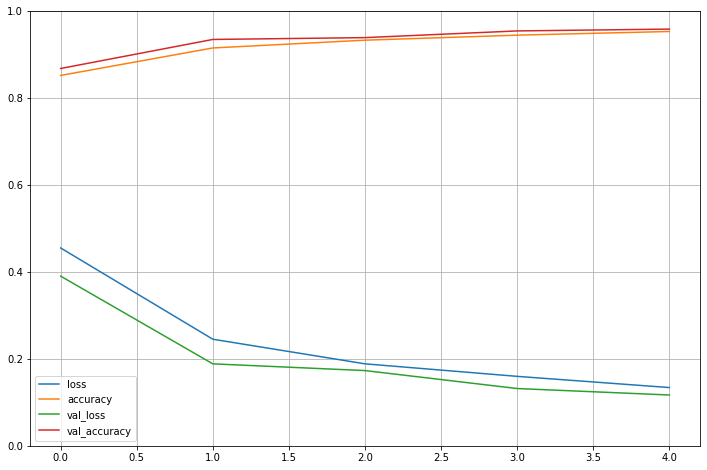

In [7]:
# Assume you have stored the training history in the variable "history"
# Show the learning curves
pd.DataFrame(history.history).plot(figsize=(12, 8))
plt.gca().set_ylim(0, 1)
plt.grid(True)
plt.show()

## Save the model

In [8]:
model5.save('cifar10.h5') 

## Load the model and evaluate it on the test data

In [9]:
model = keras.models.load_model("cifar10.h5")
model.evaluate(X_test, y_test)

313/313 [==============================] - 336s 1s/step - loss: 0.2380 - accuracy: 0.9324


[0.23795033991336823, 0.9323999881744385]

## Short report

Please write briefly how you build and train the model. Please include the decisions you made, such as how you decide the number of layers reused from the selected model, and the difficulties you met.

We used transfer learning to build a convolutional Neural Network to tackle the CIFAR-10 dataset by using the ResNet50 model, which is a very good option for our problem setting; ResNet50 (reference: https://arxiv.org/abs/1512.03385) has been created to tackle the classification problem of the ImageNet dataset, which contains data similar to CIFAR-10. Its main advantage is that it solves the vanishing gradient problem by using skip connections leading to addition, thus forming residual blocks. The gradients can flow directly through the skip connections backwards from later layers to initial filters. This also allows the creation of deeper NNs (and CNNs). Considering training time, ResNet50 is a good option since it has a relatively low number of parameters (26M) and TFLOPs. <br>
The network inputs are 32x32 images, which have been pre-processed to obtain the right formatting for the ResNet50 model (224x224).
The target variable has been categorized in 10 classes, given that the CIFAR-10 dataset consists of 50k training images and 10k testing images belonging to 10 classes. <br>

Our **baseline attempt** was to evaluate the performance of ResNet50 on the CIFAR-10 dataset. We replaced the output layer from 1000 classifications pretrained for imagenet to 10 classifications. We freeze all layers of ResNet50. The test accuracy achieved on the CIFAR-10 dataset is 89.45% after 3 epochs (and higher than validation accuracy by about 4%, possible due to the selected splitting of the data). <br>

Since CIFAR-10 contains a large enough training dataset, we decided to re-train the upper layer (stage 5) of the ResNet50 model (see image above) that calculates more specific features of the ImageNet dataset. <br>
To form our classifier we performed a **randomised search** to find the right amount of dense layers and neurons. As a result, the search provided us with a 3-layer NN, 128 HU. <br>

Since ResNet50 tackles the problem of the vanishing gradient, we expect to not encounter this problem when we have only a few hidden layers in our classifier. As a result we don't expect to encounter difficulties when applying either the ReLU or the linear activation function to our hidden layers. An initial training with the ReLU activation function and a 2-layer, 1024 HU classifier produced an accuracy of 89%. Eventually, with the 3-layer NN, 128 HU classifier we obtained higher accuracy by using the linear activation function.<br>

We also wanted to test our classifier in the model by re-training both stage 4 & 5 of ResNet50. After 3 epochs, the "trainable Stage 5 ResNet50" model outperforms it by 5.7% on the test dataset. As a result, we proceeded by fine-tuning the latter model, which we also tested for 5 epochs with 1.21% accuracy increase. The accuracies obtained by the models are presented in the Table below.

For both model structures, we applied some <u>techniques</u> to tackle the most-frequently-encountered NN problems, such as overfitting, training time and a problem that is more specifically-related to transfer learning: image rescaling.

- To account for the overfitting issue, we used **data augmentation** on both architectures; specifically, we used a rotation range of 20, horizontal flip and a zoom range of 0.1. 

- **Image resizing** is a required preprocessing step in transfer learning, to tackle the fact that CIFAR-10 has 32x32-sized images, while ResNet50 was trained using 224x224-sized ones. Thus, we need to upscale our training images if we want to re-use the model's optimal weights. We did so by adding a lambda layer at the top of the convolutional base, where the same aspect ratio of each image has been kept to avoid distortions. This preprocessing step allowed us to achieve a higher classification accuracy for all tested models.

- To optimize the model's weights, we opted for the **Adam** optimizer, an efficient optimization technique that normally converges faster. We setted a learning rate parameter of 0.001.

- To increase the performance of the "trainable Stage 5 ResNet50" model we also tested the **dropout** technique, where randomly some neurons are temporarily ignored during a training step, but may be active in another one; the dropout rate has been fine-tuned to reach the highest performance in our model, and it was set to 0.4. This led to accuracy 91.48%, showing a decrease of 0.55% when compared to the original model.

The results we obtained by evaluating the three models on the CIFAR-10 dataset are presented in the Table below:

Model Description | Classifier | Preprocessing | Test accuracy (%) |
--- | --- | --- | --- 
Basic ResNet50 | ResNet50 AvgPooling output<br>1-layer | preprocessing, image resizing, data augmentation,<br>output categorized (10 classes) | 89.45 |
trainable Stage 5 ResNet50 (3-epochs)| ResNet50 Stage 4 output<br>3-layer NN, 128 HU | preprocessing, image resizing, data augmentation,<br>output categorized (10 classes) |  92.03 | 
trainable Stage 5 ResNet50 (5-epochs)| ResNet50 Stage 4 output<br>3-layer NN, 128 HU | preprocessing, image resizing, data augmentation,<br>output categorized (10 classes) |  93.24 |
trainable Stages 4 & 5 ResNet50| ResNet50 Stage 3 output<br>3-layer NN, 128 HU| preprocessing, image resizing, data augmentation,<br>output categorized (10 classes) | 86.33 | <br>